# Effects of Parameters in the GS Model

By keeping the domain (64 X 64 square), the initial condition (a centered cluster of ones in the activator component matrix U), and all other parameters constant, we searched for the range of one specific parameter at one time that renders a stable ending state pattern. We visualized the **initial condition** and **the ending state patterns for 8 different values in the search range of each parameter** in the model. 

We chose to use ADI method to compute the solution for the PDE equations since it is comparatively the most accurate (2-nd order) and the most stable (allows the largest dt) among all the 4 methods we tried.

In [1]:
# import libraries
import numpy as np
from util import *
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
from IPython.display import HTML
%matplotlib inline

## Base Model Parameters Setup

```python
Du = 1.0 # diffusion rate of u
Dv = 0.5 # diffusion rate of v
ff = 0.055 # feed rate, same as 'f' in the model PDE equation
kk = 0.062 # kill rate, same as 'k' in the model PDE equation
```

## Change `Du`, `Dv`

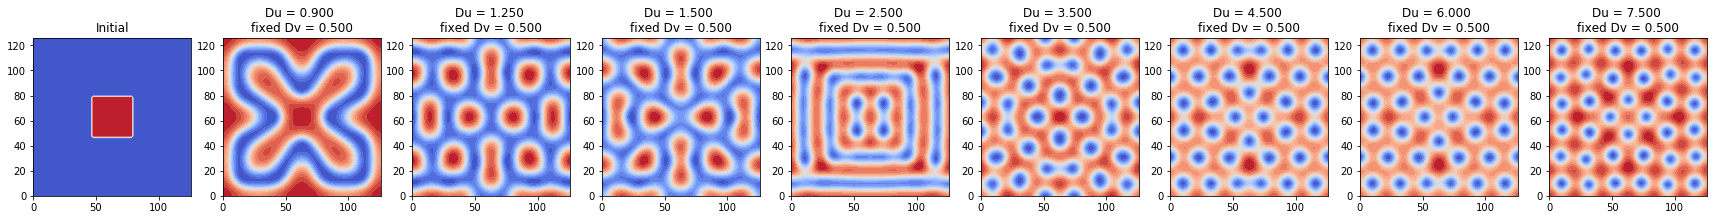

In [5]:
# Grid setup
Ny, Nx = 64, 64
h = 2
N = Nx * Ny

# Parameters setup
Du_arr = [0.9, 1.25, 1.50, 2.50, 3.50, 4.50, 6.00, 7.5]
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 1.5
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Initial condition
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
V_init[24:40, 24:40] = 1

# The array that records each ending state with the specific parameter value
V_ends = np.zeros((len(Du_arr)+1, Ny, Nx))
V_ends[0] = np.copy(V_init)

# The array of all plots' titles
titles = []
titles.append('Initial')

# For each Du, generate pattern and save the ending state
for idx, Du in enumerate(Du_arr):

    # Construct transform matrices
    D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
    D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
    Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
    Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
    Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
    Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

    # Factorize matrices
    solve_Tu_x = linalg.factorized(Tu_x.tocsc())
    solve_Tu_y = linalg.factorized(Tu_y.tocsc())
    solve_Tv_x = linalg.factorized(Tv_x.tocsc())
    solve_Tv_y = linalg.factorized(Tv_y.tocsc())

    # Initial condition
    U = np.zeros((time_steps, Ny, Nx))
    V = np.zeros((time_steps, Ny, Nx))
    U[0] = np.copy(U_init)
    V[0] = np.copy(V_init)

    # Generate pattern
    for i in range(1, time_steps):

        # Stage one - solve along x direction
        b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) \
            + (1 - 0.5 * dt * V[i - 1] ** 2 - 0.5 * dt * ff) * U[i - 1] + 0.5 * dt * ff
        b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
            + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V[i - 1] + 0.5 * dt * U[i - 1] * V[i - 1] ** 2

        U_middle = solve_Tu_x(b1U.T)
        V_middle = solve_Tv_x(b1V.T)

        # Stage two - solve along y direction
        b2U = 0.5 * Du * c * D2x.dot(U_middle) \
            + (1 - 0.5 * dt * V_middle ** 2 - 0.5 * dt * ff) * U_middle + 0.5 * dt * ff
        b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
            + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V_middle + 0.5 * dt * U_middle * V_middle ** 2

        U[i] = solve_Tu_y(b2U.T)
        V[i] = solve_Tv_y(b2V.T)
        
    V_ends[idx + 1] = U[-1]
    titles.append('Du = %.3f \nfixed Dv = %.3f' % (Du_arr[idx], Dv))

plot_pattern_end_states(V_ends, titles, h)

dt = 1.5, time_steps = 6666


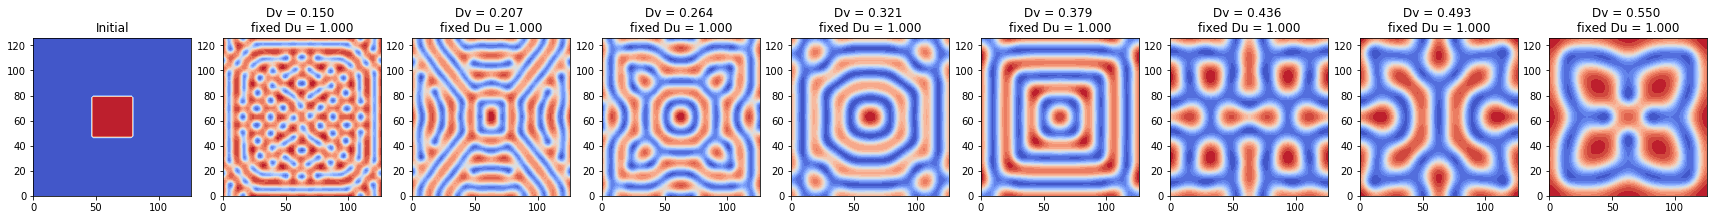

In [8]:
# Grid setup
Ny, Nx = 64, 64
h = 2
N = Nx * Ny

# Parameters setup
Du = 1
Dv_arr = np.linspace(0.15, 0.55, 8)
ff = 0.055
kk = 0.062

# Time steps
dt = 1.5
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Initial condition
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
V_init[24:40, 24:40] = 1

# The array that records each ending state with the specific parameter value
V_ends = np.zeros((len(Dv_arr)+1, Ny, Nx))
V_ends[0] = np.copy(V_init)

# The array of all plots' titles
titles = []
titles.append('Initial')

# For each Dv, generate pattern and save the ending state
for idx, Dv in enumerate(Dv_arr):
    # Initial conditions
    U = np.zeros((time_steps, Ny, Nx))
    V = np.zeros((time_steps, Ny, Nx))
    U[0] = np.copy(U_init)
    V[0] = np.copy(V_init)

    for i in range(1, time_steps):
        # Construct transform matrices
        D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
        D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
        Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
        Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
        Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
        Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

        # Factorize matrices
        solve_Tu_x = linalg.factorized(Tu_x.tocsc())
        solve_Tu_y = linalg.factorized(Tu_y.tocsc())
        solve_Tv_x = linalg.factorized(Tv_x.tocsc())
        solve_Tv_y = linalg.factorized(Tv_y.tocsc())

        # Stage one - solve along x direction
        b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) \
            + (1 - 0.5 * dt * V[i - 1] ** 2 - 0.5 * dt * ff) * U[i - 1] + 0.5 * dt * ff
        b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
            + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V[i - 1] + 0.5 * dt * U[i - 1] * V[i - 1] ** 2

        U_middle = solve_Tu_x(b1U.T)
        V_middle = solve_Tv_x(b1V.T)

        # Stage two - solve along y direction
        b2U = 0.5 * Du * c * D2x.dot(U_middle) \
            + (1 - 0.5 * dt * V_middle ** 2 - 0.5 * dt * ff) * U_middle + 0.5 * dt * ff
        b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
            + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V_middle + 0.5 * dt * U_middle * V_middle ** 2

        U[i] = solve_Tu_y(b2U.T)
        V[i] = solve_Tv_y(b2V.T)
    
    V_ends[idx + 1] = U[-1]
    titles.append('Dv = %.3f \nfixed Du = %.3f' % (Dv_arr[idx], Du))

plot_pattern_end_states(V_ends, titles, h)

**Observation**: To get a stable pattern modeled by GS model, we must have Dv << Du (diffusion rate of the activator V must be much smaller than the that of the substrater U):

- when fix Dv = 0.5, Du $\sim$ (0.9, 7.5); 

- when fix Du = 1, Dv $\sim$ (0.15, 0.55).

## Change `ff`

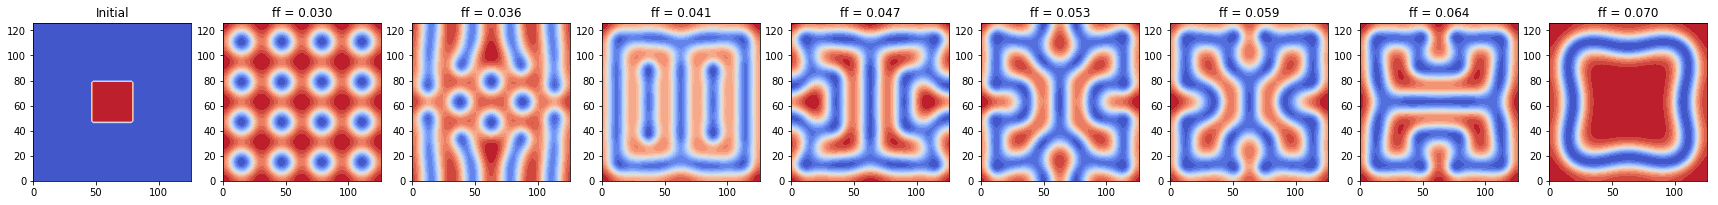

In [17]:
# Grid setup
Ny, Nx = 64, 64
h = 2
N = Nx * Ny

# Parameters setup
Du = 1
Dv = 0.5
ff_arr = np.linspace(0.030, 0.070, 8)
kk = 0.062

# Time steps
dt = 1.5
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Initial condition
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
V_init[24:40, 24:40] = 1

# The array that records each ending state with the specific parameter value
V_ends = np.zeros((len(ff_arr)+1, Ny, Nx))
V_ends[0] = np.copy(V_init)

# The array of all plots' titles
titles = []
titles.append('Initial')

# For each ff, generate pattern and save the ending state
for idx, ff in enumerate(ff_arr):
    # Initial condition
    U = np.zeros((time_steps, Ny, Nx))
    V = np.zeros((time_steps, Ny, Nx))
    U[0] = np.copy(U_init)
    V[0] = np.copy(V_init)

    # Generate pattern
    for i in range(1, time_steps):
        # Stage one - solve along x direction
        b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) \
            + (1 - 0.5 * dt * V[i - 1] ** 2 - 0.5 * dt * ff) * U[i - 1] + 0.5 * dt * ff
        b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
            + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V[i - 1] + 0.5 * dt * U[i - 1] * V[i - 1] ** 2

        U_middle = solve_Tu_x(b1U.T)
        V_middle = solve_Tv_x(b1V.T)

        # Stage two - solve along y direction
        b2U = 0.5 * Du * c * D2x.dot(U_middle) \
            + (1 - 0.5 * dt * V_middle ** 2 - 0.5 * dt * ff) * U_middle + 0.5 * dt * ff
        b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
            + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V_middle + 0.5 * dt * U_middle * V_middle ** 2

        U[i] = solve_Tu_y(b2U.T)
        V[i] = solve_Tv_y(b2V.T)
    
    V_ends[idx + 1] = U[-1]
    titles.append('ff = %.3f' % (ff_arr[idx]))

plot_pattern_end_states(V_ends, titles, h)


**Observation**: For stability,

- ff $\sim$ (0.030, 0.070).

## Change `kk`

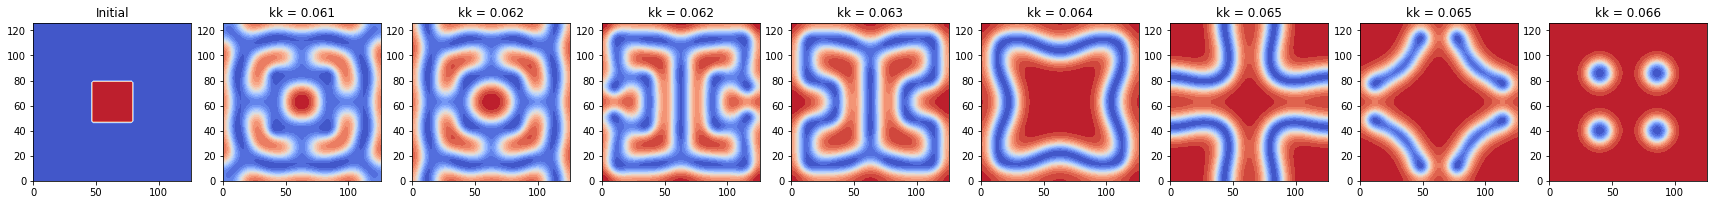

In [18]:
# Grid setup
Ny, Nx = 64, 64
h = 2
N = Nx * Ny

# Parameters setup
Du = 1
Dv = 0.5
ff = 0.055
kk_arr = np.linspace(0.061, 0.066, 8)

# Time steps
dt = 1.5
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Initial condition
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
V_init[24:40, 24:40] = 1

# The array that records each ending state with the specific parameter value
V_ends = np.zeros((len(kk_arr)+1, Ny, Nx))
V_ends[0] = np.copy(V_init)

# The array of all plots' titles
titles = []
titles.append('Initial')

# For each kk, generate pattern and save the ending state
for idx, kk in enumerate(kk_arr):
    # Initial condition
    U = np.zeros((time_steps, Ny, Nx))
    V = np.zeros((time_steps, Ny, Nx))
    U[0] = np.copy(U_init)
    V[0] = np.copy(V_init)

    # Generate pattern
    for i in range(1, time_steps):

        # Stage one - solve along x direction
        b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) \
            + (1 - 0.5 * dt * V[i - 1] ** 2 - 0.5 * dt * ff) * U[i - 1] + 0.5 * dt * ff
        b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
            + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V[i - 1] + 0.5 * dt * U[i - 1] * V[i - 1] ** 2

        U_middle = solve_Tu_x(b1U.T)
        V_middle = solve_Tv_x(b1V.T)

        # Stage two - solve along y direction
        b2U = 0.5 * Du * c * D2x.dot(U_middle) \
            + (1 - 0.5 * dt * V_middle ** 2 - 0.5 * dt * ff) * U_middle + 0.5 * dt * ff
        b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
            + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V_middle + 0.5 * dt * U_middle * V_middle ** 2

        U[i] = solve_Tu_y(b2U.T)
        V[i] = solve_Tv_y(b2V.T)
    
    V_ends[idx + 1] = U[-1]
    titles.append('kk = %.3f' % (kk_arr[idx]))

plot_pattern_end_states(V_ends, titles, h)

**Observation**: For stability, 

- kk $\sim$ (0.061, 0.066).

## Summary
Each parameter in the GS model should stay within its range for generating a stable pattern.  

- Diffusion rates `Du`, `Dv`:
    - when fix Dv = 0.5, Du $\sim$ (0.9, 7.5); 
    - when fix Du = 1, Dv $\sim$ (0.15, 0.55).
    - The diffusion rate of the activator (`Dv`) should be much smaller than the the diffusion rate of the substrate (`Du`). In this way, we maintained the conditions for **short-range autocatalytic process** and the **long-range inhibitory process**.


- Feed rate `ff` and kill rate `kk`:
    - when fixed `kk`=0.062, `ff` $\sim$ (0.030, 0.070)
    - when fixed `ff`=0.055, `kk` $\sim$ (0.061, 0.066)
    - Referring to [Pearson's Parametrization](http://mrob.com/pub/comp/xmorphia/), different combination of specific feed rate and kill rate renders different types of patterns. Based on our experiments with initial condition as a centered cluster of ones in the activator component, we got equally spaced spots, square-like patterns, and symmetric stripes at the 4 corners of the square domain.

